**This is part two for my Exploratory Data Analysis for the gaming dataset. My part 1 can be found at:<br>**
https://www.kaggle.com/etakla/d/rush4ratio/video-game-sales-with-ratings/exploring-the-dataset-univariate-analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

from IPython.display import display, HTML
# Any results you write to the current directory are saved as output.

#For plotting
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
%matplotlib inline

Video_Games_Sales_as_at_22_Dec_2016.csv



In [2]:
vg_df = pd.read_csv('../input/Video_Games_Sales_as_at_22_Dec_2016.csv')
vg_df.User_Score = vg_df.User_Score.convert_objects(convert_numeric=True)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


# Bivariate General Overview

## Correlation

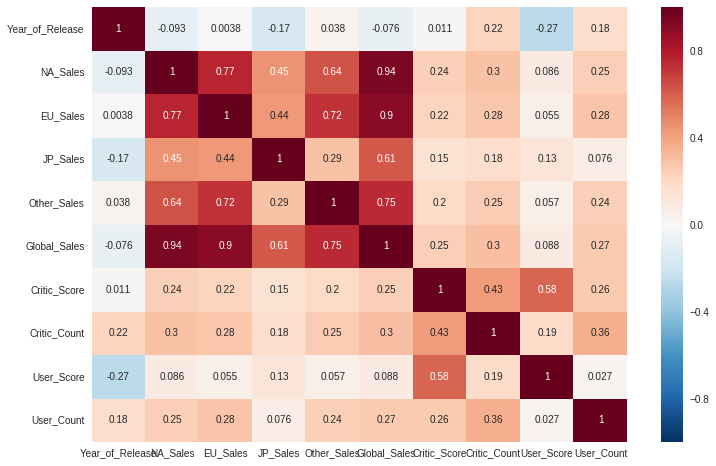

In [3]:
plt.figure(figsize=(12, 8))

vg_corr = vg_df.corr()
sns.heatmap(vg_corr, 
            xticklabels = vg_corr.columns.values,
            yticklabels = vg_corr.columns.values,
            annot = True);

## Crossplots

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


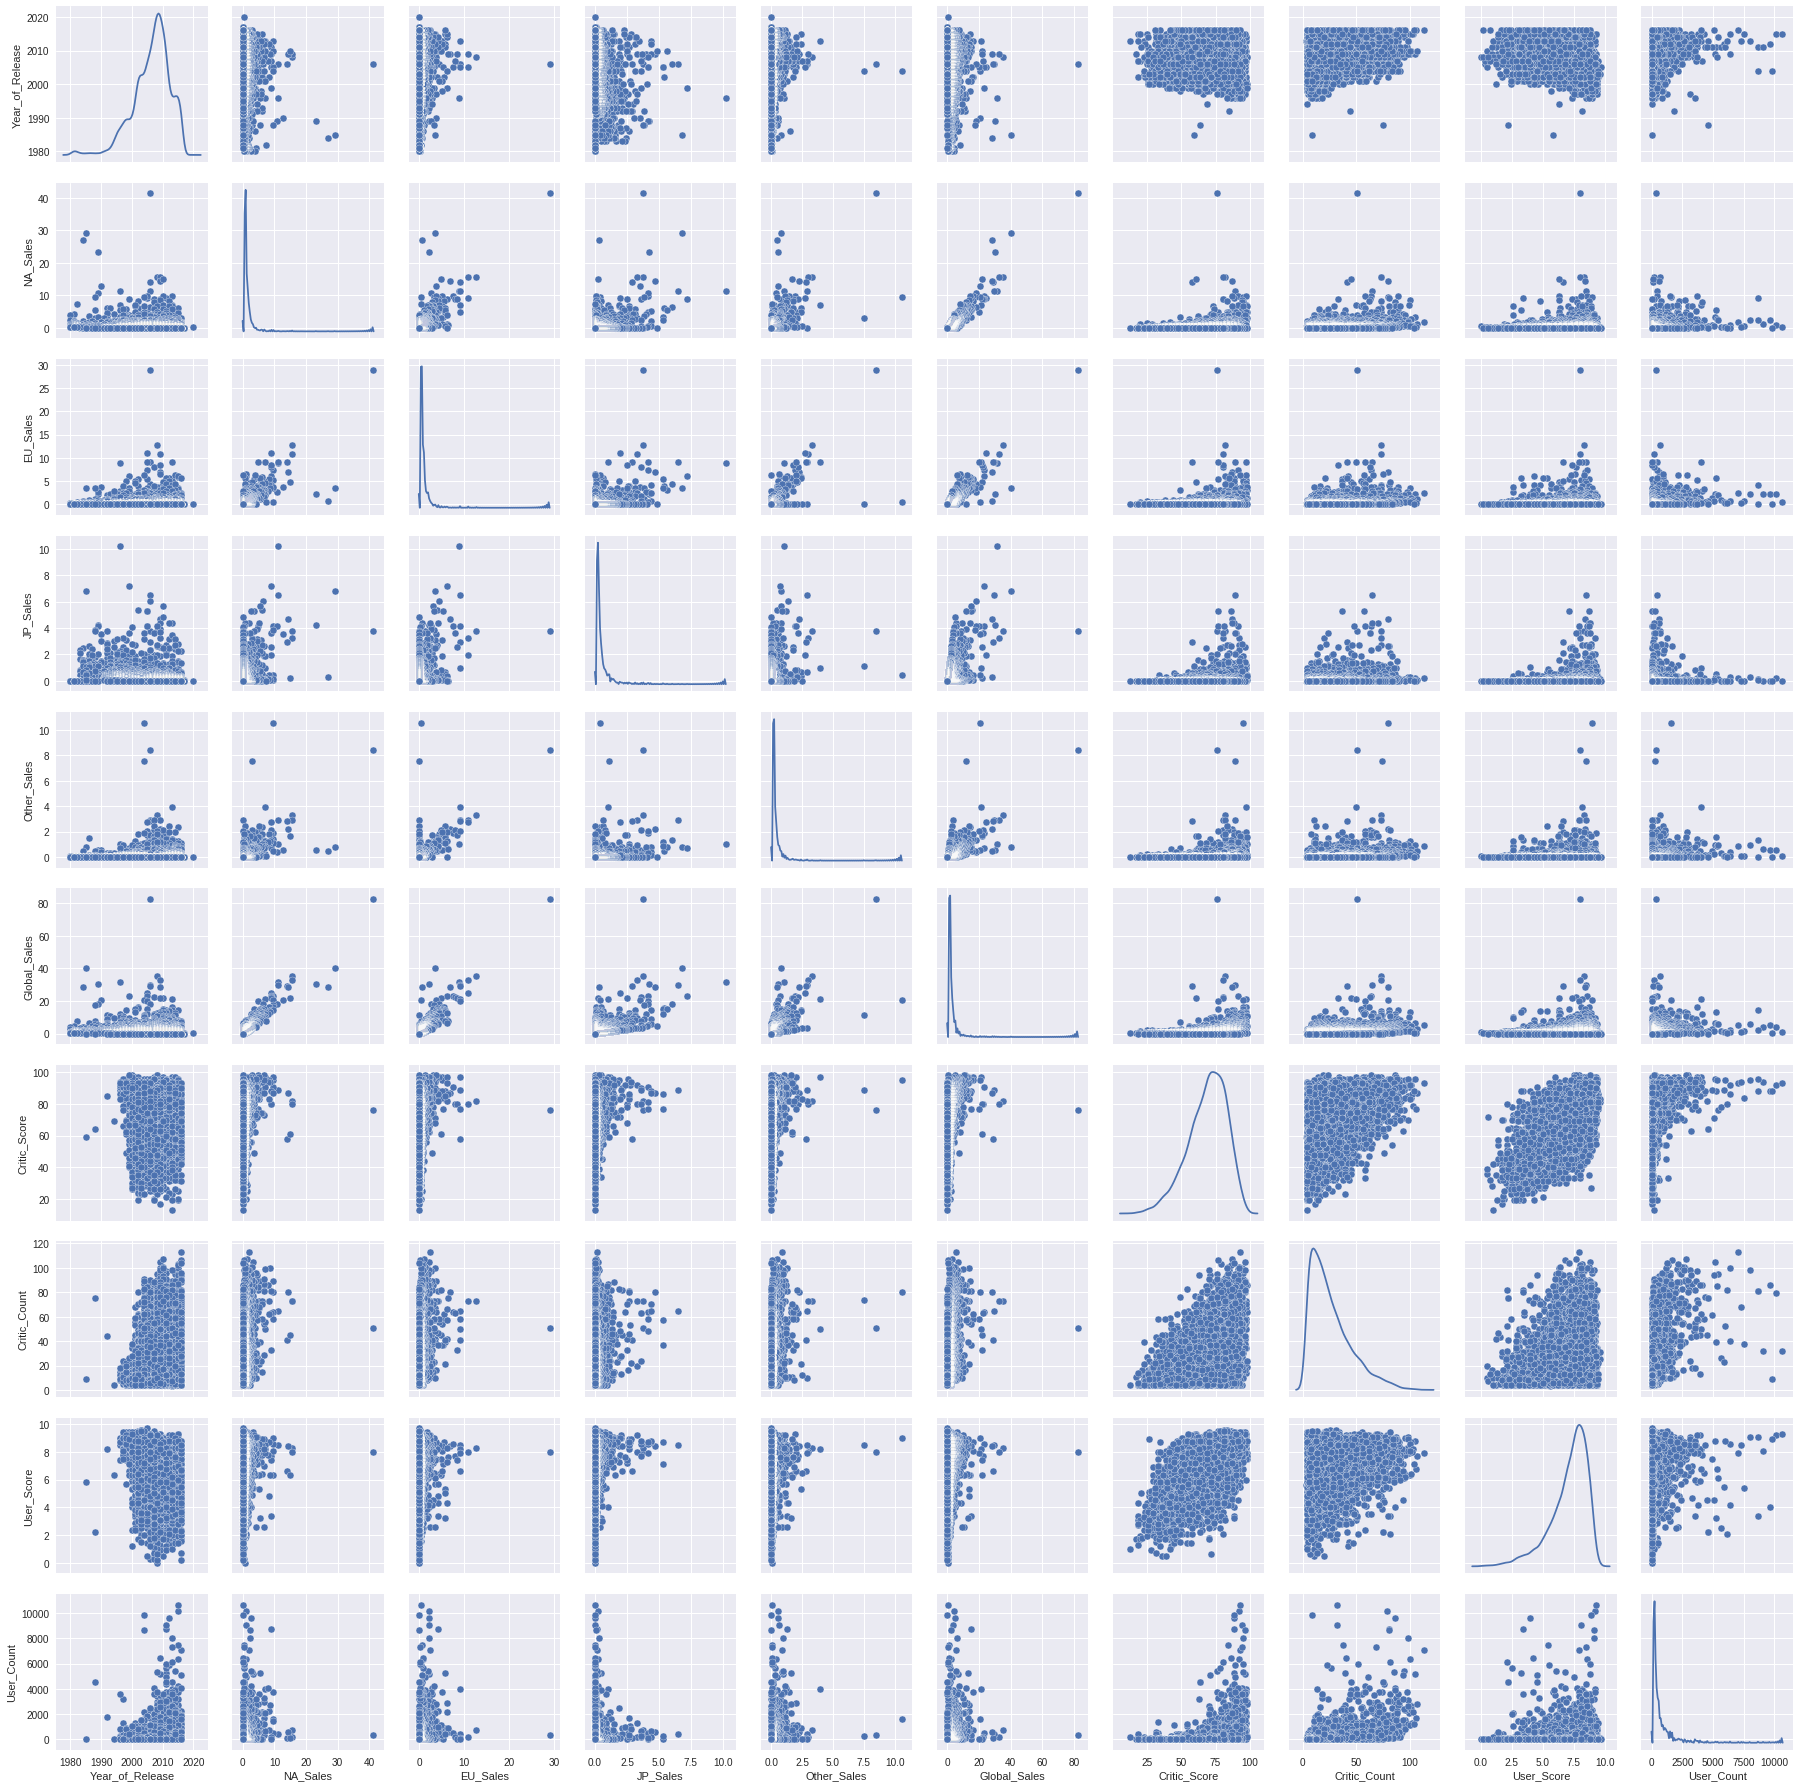

In [4]:
plt.figure(figsize=(14, 14))

sns.pairplot(vg_df, diag_kind='kde');

# Evolution Over Time

## Sales vs Number of Releases

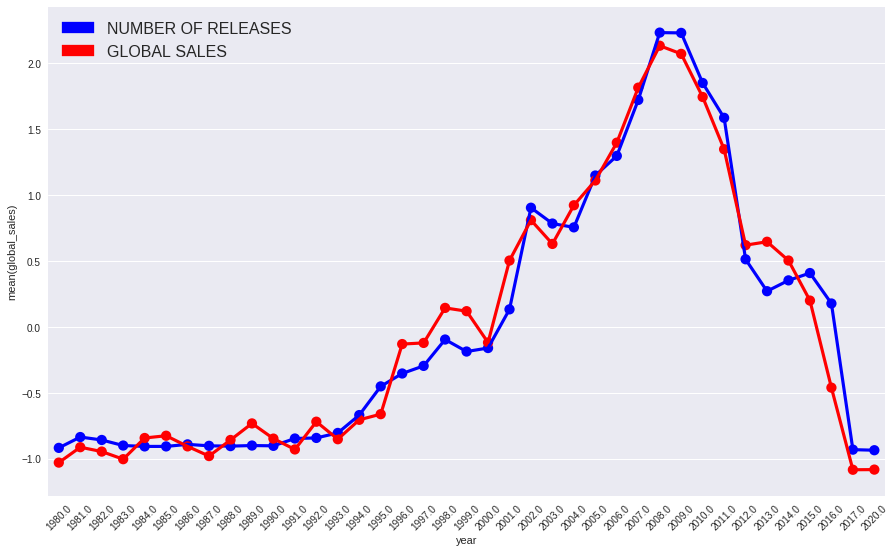

In [5]:
#Group the entries by year, then get how many entries are there; i.e. the number of releases
temp1 = vg_df.groupby(['Year_of_Release']).count()
temp1 = temp1.reset_index()

#Do the same, but sum the values to get the total values of everything by year.
temp2 = vg_df.groupby(['Year_of_Release']).sum()
temp2 = temp2.reset_index()

#Normalize the data, i.e. zero mean and unit std. I did this to be able to compare the shapes of both graphs, since 
#they have different ranges
normalised_df = pd.DataFrame()

normalised_df['release_count'] = temp1['Name']
normalised_df['global_sales'] = temp2['Global_Sales']
normalised_df = (normalised_df - normalised_df.mean()) / normalised_df.std()#(normalised_df.max() - normalised_df.min()) 
normalised_df['year'] = temp1['Year_of_Release']


#Plot
plt.figure(figsize=(15, 9))
ax = sns.pointplot(x = normalised_df.year, y = normalised_df.release_count, color = 'blue', label='Release Count')
ax = sns.pointplot(x = normalised_df.year, y = normalised_df.global_sales, color = 'red', label='Global Sales')

blue_patch = mpatches.Patch(color='blue', label='NUMBER OF RELEASES')
red_patch = mpatches.Patch(color='red', label='GLOBAL SALES')
plt.legend(handles=[blue_patch, red_patch], loc='upper left', fontsize = 16)

plt.xticks(rotation=45);

The shapes follow each other well, there wasn't any weird too much sales with little releases or vice versa. The other thing to note is that the number of releases is smoother than the sales, which seem to harder to accurately predict.

## Genre Sales Evolution

These are two plots, the first is an area plot to see the precentage of sales of each genre over the years. The second is the sales by year (Although still divided by genre). This last one is just for convenience, to remember how the games sales were.

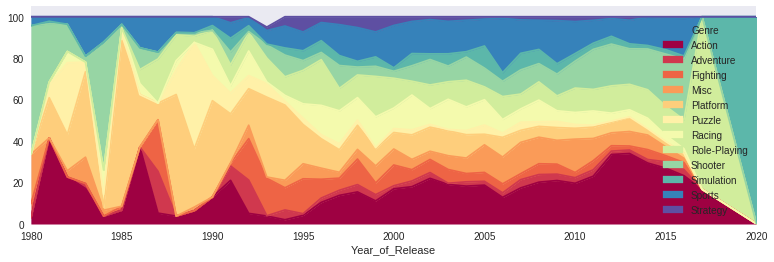

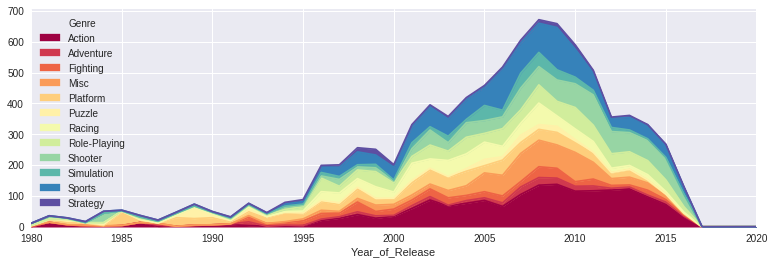

In [6]:
fig = plt.figure(figsize=(10, 8))

genre_sales_percentages_by_year = (vg_df.groupby(['Year_of_Release', 'Genre']).Global_Sales.sum())*(100)/vg_df.groupby(['Year_of_Release']).Global_Sales.sum()
genre_sales_percentages_by_year.unstack().plot(kind='area',stacked=True, colormap= 'Spectral', grid=False, figsize=(13, 4))

yearlySales = vg_df.groupby(['Year_of_Release','Genre']).Global_Sales.sum()
yearlySales.unstack().plot(kind='area',stacked=True, colormap= 'Spectral', figsize=(13, 4) ) ;

The "action" genre is clearly what gamers are inclined to play the most. The interesting trend about it is that when the games sales started their decline around 2009, the "action" level remained **almost the same**. So this genre may seem to be resistent to hard-hit markets?  

## Genre Total Sales

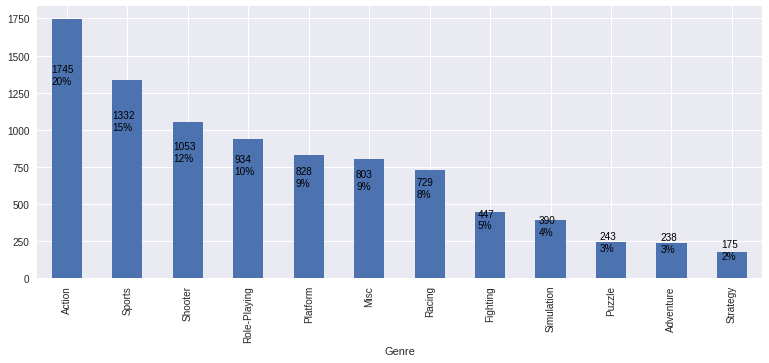

In [7]:
x = vg_df.groupby(['Genre']).sum().copy()
ax = x.Global_Sales.sort_values(ascending=False).plot(kind='bar', figsize=(13, 5));

for p in ax.patches:
    ax.annotate(str( round( p.get_height() ) ) + "\n" + str(round( p.get_height() /89.170) )+ "%", 
                (p.get_x() * 1.007, p.get_height() * 0.75),
                color='black')

Although there are changes in ranking, but there are no big surprises (By the number of releases, the rank was Action, Sports, Misc (Rank changed in sales), Role Playing, Shooter (Changed, sells more than it is released)..etc. For more information, refer to the first part, the univariate analysis)

But these changes in ranking are interesting to explore more. I want to see how different genres perform according to different metrics. The ones I chose are:<br>
1) Number of Releases<br>
2) Total Sales<br>
3) Average Sales per Game

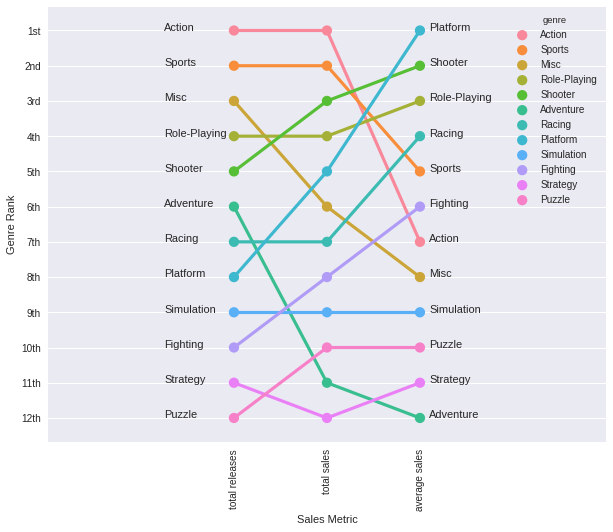

In [8]:
#First is the number of releases per genre, second is the sales per genre, third is the average sales per game per genre
genre_difference_metric = [vg_df.Genre.value_counts().index, vg_df.groupby(['Genre']).sum().Global_Sales.sort_values(ascending=False).index, vg_df.groupby(['Genre']).mean().Global_Sales.sort_values(ascending=False).index]

#Dataframe to be used for plotting.
genre_evolution_df = pd.DataFrame(columns=['genre', 'rank_type', 'rank'])

#Populate the dataframe
for metric in range(3):
    for genre in range(len(genre_difference_metric[metric])):
        genre_evolution_df = genre_evolution_df.append({'genre':genre_difference_metric[metric][genre], 'rank_type': metric, 'rank':genre},
                                   ignore_index=True)

        
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

sns.pointplot(x=genre_evolution_df.rank_type,
              y=12-genre_evolution_df['rank'], 
              hue=genre_evolution_df.genre)

for i in range(len(genre_difference_metric[0])):
    ax.text(-0.75, 12-i, genre_difference_metric[0][i], fontsize=11)
    ax.text(2.1, 12-i, genre_difference_metric[2][i], fontsize=11)
    
ax.set_xlim([-2,4])

xs = [0.0, 1.0, 2.0]
x_labels = ['total releases', 'total sales', 'average sales']
plt.xticks(xs, x_labels, rotation='vertical')

ax.set_xlabel('Sales Metric')

ys = range(1,13)
y_labels = ['12th', '11th', '10th', '9th', '8th', '7th', '6th', '5th', '4th', '3rd', '2nd', '1st']
plt.yticks(ys, y_labels)
ax.set_ylabel('Genre Rank')

plt.show();

I think that the graph is pretty interesting! Lots of interpretations can be made here.

## Rating Sales Evolution

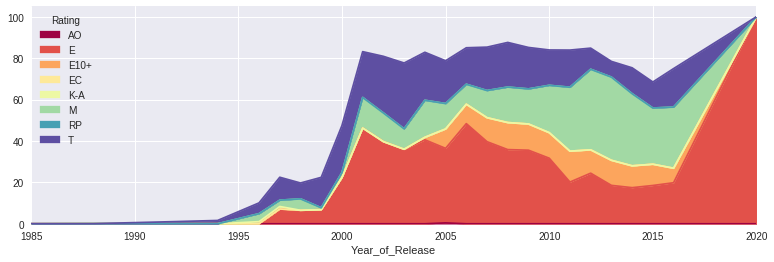

In [9]:
rating_sales_percentages_by_year = (vg_df.groupby(['Year_of_Release', 'Rating']).Global_Sales.sum())*(100)/vg_df.groupby(['Year_of_Release']).Global_Sales.sum()
rating_sales_percentages_by_year.unstack().plot(kind='area',stacked=True, colormap= 'Spectral', figsize=(13, 4));

This is a percentage area graph. So, the empty (grey) parts mean that a rating was missing.

# Scores

## Critic vs User Scores

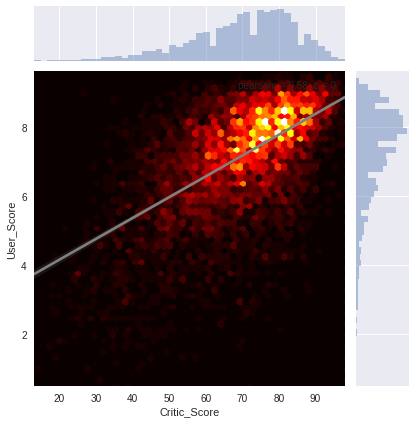

In [10]:
g = sns.jointplot(x = 'Critic_Score', 
              y = 'User_Score',
              data = vg_df, 
              kind = 'hex', 
              cmap= 'hot', 
              size=6)

#http://stackoverflow.com/questions/33288830/how-to-plot-regression-line-on-hexbins-with-seaborn
sns.regplot(vg_df.Critic_Score, vg_df.User_Score, ax=g.ax_joint, scatter=False, color='grey');

The user scores appear to be more generous than the critic one. But which one has a better correlation with the sales? From the first graph, we can see that, clearly, the critic score correlates better with the sales. In fact, the user score does **not correlate at all** with the sales, it floats around the zero! (Except for the sales in Japan, but still a lower correlation than the critic's one)

# Regional Sales

## Scatterplot between Global Sales and Regional Sales

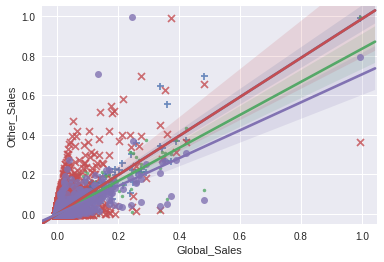

In [11]:
sales_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
sales_normalised_df = vg_df[sales_cols].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))

sns.regplot(x = sales_normalised_df.Global_Sales, y = sales_normalised_df.NA_Sales,    marker="+")
sns.regplot(x = sales_normalised_df.Global_Sales, y = sales_normalised_df.EU_Sales,    marker=".")
sns.regplot(x = sales_normalised_df.Global_Sales, y = sales_normalised_df.JP_Sales,    marker="x")
sns.regplot(x = sales_normalised_df.Global_Sales, y = sales_normalised_df.Other_Sales, marker="o")

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
fig.tight_layout();

## Regional Sales of Genres

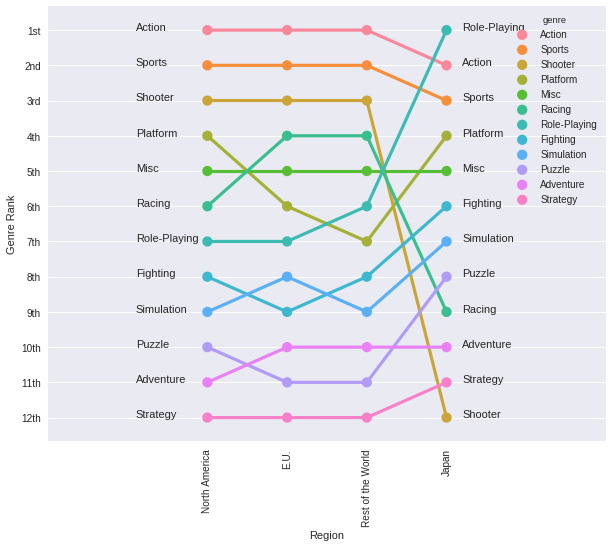

In [12]:
genre_geo_rankings = [vg_df.groupby('Genre').sum().unstack().NA_Sales.sort_values(ascending=False).index, 
                      vg_df.groupby('Genre').sum().unstack().EU_Sales.sort_values(ascending=False).index,
                      vg_df.groupby('Genre').sum().unstack().Other_Sales.sort_values(ascending=False).index,
                      vg_df.groupby('Genre').sum().unstack().JP_Sales.sort_values(ascending=False).index
                      ]

#First is the number of releases per genre, second is the sales per genre, third is the average sales per game per genre
genre_geo_rank_df = pd.DataFrame(columns=['genre', 'rank_type', 'rank'])

#for metric in genre_difference_metric:
for region in range(4):
    for genre in range(len(genre_geo_rankings[region])):
        genre_geo_rank_df = genre_geo_rank_df.append({'genre':genre_geo_rankings[region][genre], 'rank_type': region, 'rank':genre},
                                   ignore_index=True)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

sns.pointplot(x=genre_geo_rank_df.rank_type,
              y=12-genre_geo_rank_df['rank'], 
              hue=genre_geo_rank_df.genre)

for i in range(len(genre_geo_rankings[0])):
    ax.text(-0.9, 12-i, genre_geo_rankings[0][i], fontsize=11)
    ax.text(3.2, 12-i, genre_geo_rankings[3][i], fontsize=11)
    
ax.set_xlim([-2,5])

xs = [0.0, 1.0, 2.0, 3.0]
x_labels = ['North America', 'E.U.', 'Rest of the World', 'Japan']
plt.xticks(xs, x_labels, rotation='vertical')
ax.set_xlabel('Region')

ys = range(1,13)
y_labels = ['12th', '11th', '10th', '9th', '8th', '7th', '6th', '5th', '4th', '3rd', '2nd', '1st']
plt.yticks(ys, y_labels)
ax.set_ylabel('Genre Rank')

plt.show();

I think there are a lot of insights from this graph. Mainly, the taste of gamers in Japan is really different than that of the three other regions. The remaining three regions are, more or less, similar; with maybe only platform and racing genres moving more than one position between the three regions.

# Most Selling Platform Each Year

I will plot the top selling platform timeline. In the beginning the plot had all the platforms sales, but the result had too much information to digest, it was too clutered. The graph is followed by a table that describes the same thing, just for convenience

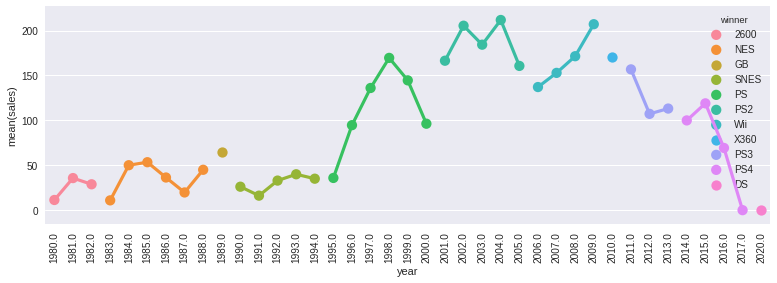

In [13]:
#temp is the sum of all variables for each platform by year
temp = vg_df.groupby(['Year_of_Release', 'Platform']).sum().reset_index().groupby('Year_of_Release')

platform_yearly_winner_df = pd.DataFrame()

for year, group in temp:
    current_year = temp.get_group(year)
    this_year_max_sales = 0.0
    current_year_winner = ""
    row = {'year':"", 'winner':"", 'sales':""}
    for index, platform_data in current_year.iterrows():
        if platform_data.Global_Sales > this_year_max_sales:
            this_year_max_sales = platform_data.Global_Sales
            current_year_winner = platform_data.Platform
    
    row['year'] = year
    row['winner'] = current_year_winner
    row['sales'] = this_year_max_sales
    platform_yearly_winner_df = platform_yearly_winner_df.append(row, ignore_index=True)

fig = plt.figure(figsize=(13, 4))

g = sns.pointplot(x = platform_yearly_winner_df.year ,
              y = platform_yearly_winner_df.sales , 
              hue = platform_yearly_winner_df.winner);

#http://stackoverflow.com/questions/26540035/rotate-label-text-in-seaborn-factorplot
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [14]:
platform_yearly_winner_df.set_index('year', inplace=True)
HTML(platform_yearly_winner_df.to_html())

,sales,winner
year,,
1980.0,11.38,2600
1981.0,35.77,2600
1982.0,28.86,2600
1983.0,10.96,NES
1984.0,50.09,NES
1985.0,53.44,NES
1986.0,36.41,NES
1987.0,19.76,NES
1988.0,45.01,NES


# Publishers

## Top Publishers of all Time

When thinking about what the term "top publisher" means, I think it has no simple answer. So I have decided to explore the matter from different points of view, and see if there are certain names that consistantly appear in all the points of view.

### By Sales

In [15]:
x = vg_df.groupby(['Publisher']).sum().Global_Sales.copy()
x.sort_values(ascending=False, inplace=True)
x.head(10)

Publisher
Nintendo                        1788.81
Electronic Arts                 1116.96
Activision                       731.16
Sony Computer Entertainment      606.48
Ubisoft                          471.61
Take-Two Interactive             403.82
THQ                              338.44
Konami Digital Entertainment     282.39
Sega                             270.35
Namco Bandai Games               254.62
Name: Global_Sales, dtype: float64

### By Number of Releases

In [16]:
x = vg_df.groupby(['Publisher']).count().Name.copy()
x.sort_values(ascending=False, inplace=True)
x.head(10)

Publisher
Electronic Arts                 1356
Activision                       985
Namco Bandai Games               939
Ubisoft                          933
Konami Digital Entertainment     834
THQ                              715
Nintendo                         706
Sony Computer Entertainment      687
Sega                             638
Take-Two Interactive             422
Name: Name, dtype: int64

The interesting part is that the publishers who made it to the top 10 in both lists are the same, with just a different ordering.

### By Average Yearly Earning

In [17]:
#http://stackoverflow.com/questions/30328646/python-pandas-group-by-in-group-by-and-average
vg_df.groupby(['Publisher', 'Year_of_Release'], as_index=False).mean().groupby('Publisher').mean().Global_Sales.sort_values(ascending=False).head(10)

Publisher
Palcom                                4.170000
Nintendo                              2.911224
Red Orb                               2.620000
RedOctane                             2.485000
Arena Entertainment                   2.360000
UEP Systems                           2.250000
Hello Games                           1.700000
Valve                                 1.700000
Sony Computer Entertainment Europe    1.637857
Microsoft Game Studios                1.581036
Name: Global_Sales, dtype: float64

There was something that intuitively I didn't like about this last list. After some investigation, I found that there were some publishers who did not stay in the market for long, but had made some strong sales. I am not sure if this makes a publisher make it towards the top list of all time, but I have decided to add the condition that a top publisher must have been in the competition for more than 5 years. I am not sure if I am subconsciously pushing some names to reappear into this again, maybe because that makes it clearer who deserves to be on that list.

In [18]:
vg_df.groupby(['Publisher']).filter(lambda x: len(x) > 5).groupby(['Publisher', 'Year_of_Release'], as_index=False).mean().groupby('Publisher').mean().Global_Sales.sort_values(ascending=False).head(10)

Publisher
Nintendo                              2.911224
Sony Computer Entertainment Europe    1.637857
Microsoft Game Studios                1.581036
Enix Corporation                      1.565476
Universal Interactive                 1.357778
Take-Two Interactive                  1.128485
SquareSoft                            1.103897
Hasbro Interactive                    0.954643
Sony Computer Entertainment           0.915346
Bethesda Softworks                    0.911188
Name: Global_Sales, dtype: float64

Still, some new names reappeared. But I am satisfied with the 5 years condition, so I am going to continue with this last list.

### By Average Earning per Game

In [19]:
x = vg_df.groupby(['Publisher']).mean().Global_Sales.copy()
x.sort_values(ascending=False, inplace=True)
x.head(10)

Publisher
Palcom                                4.170000
Red Orb                               2.620000
Nintendo                              2.533725
Arena Entertainment                   2.360000
UEP Systems                           2.250000
RedOctane                             2.170000
Valve                                 1.700000
Hello Games                           1.700000
Sony Computer Entertainment Europe    1.558000
Westwood Studios                      1.550000
Name: Global_Sales, dtype: float64

Again, the same dilemma of publishers with little publishings making great sales and reappearing on the top list. This time, I am setting a condition of having released at least 10 games before competing for the first places. For example, the first place: Palcom. It is very interesting how, by a good margin, they are well ahead of the rest. 

In [20]:
vg_df[vg_df.Publisher == 'Palcom']

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
279,Teenage Mutant Ninja Turtles,NES,1989.0,Action,Palcom,3.38,0.44,0.31,0.04,4.17,NaN,NaN,NaN,NaN,NaN,NaN


So it released one game (And this makes sense to have this company on the top of the list). It was a big hit, making over 4 million 1989 dollars! Certainly impressive, but I am not sure if this is enough to make it one of the top publishers of all time. million 1989 dollars! Personally I don't like the fact that the average is topped by a publisher that made a single release, no matter how successful this release was. I will filter out publishers who published less than 10 games and then recompute the average

In [21]:
vg_df.groupby(['Publisher']).filter(lambda x: len(x) > 10).groupby(['Publisher']).Global_Sales.mean().sort_values(ascending=False).head(10)

Publisher
Nintendo                              2.533725
Sony Computer Entertainment Europe    1.558000
Microsoft Game Studios                1.300105
Enix Corporation                      1.124667
Bethesda Softworks                    1.119079
SquareSoft                            1.108654
Take-Two Interactive                  0.956919
LucasArts                             0.953667
989 Studios                           0.951429
Hasbro Interactive                    0.951250
Name: Global_Sales, dtype: float64

## Top Publishers Final List

So the list of top publisher is the union of the top 10 highest sales, top 10 highest release, top 10 highest average sales for publishers who have released more than 10 games and top 10 highest average sales for publishers who have been around for over 5 years. The "over 10 games" and "over 5 years" are just arbitrary values that seem reasonable to me, but feel free to experiment with these values (Change the value inside the lambda function within the filters)

In [22]:
top_publishers = ['Electronic Arts', 'Activision', 'Namco Bandai Games', 'Ubisoft', 'Konami Digital Entertainment', \
                  'THQ', 'Nintendo', 'Sony Computer Entertainment', 'Sega', 'Take-Two Interactive',
                  'Sony Computer Entertainment Europe', 'Microsoft Game Studios', 'Enix Corporation', 'Bethesda Softworks', 'SquareSoft'\
                  'Take-Two Interactive', 'LucasArts', '989 Studios', 'Hasbro Interactive', 'Universal Interactive']
#You can use set to create the list, I just have handtyped them just to be more attentive to the names.

top_publisher_df = vg_df[ vg_df['Publisher'].isin(top_publishers) ]

### How do these top publishers make-up of the gaming market?

#### Number of releases

In [23]:
print("They make", 100*top_publisher_df.shape[0]/float(vg_df.shape[0]),"% of the number of releases in this dataset")

They make 51.857168490938456 % of the number of releases in this dataset


#### Total Sales

In [24]:
total_games_sales = vg_df.Global_Sales.sum()
top_publisher_total_sales = top_publisher_df.Global_Sales.sum()

print("Total Video Games Sales:", total_games_sales, "Million US$")
print("Total Top Publishers Sales:", top_publisher_total_sales, "Million US$")
print("They make ", 100*top_publisher_total_sales/total_games_sales,"% of the total video games sales")

Total Video Games Sales: 8920.300000001298 Million US$
Total Top Publishers Sales: 6787.260000000119 Million US$
They make  76.08779973766725 % of the total video games sales


### Favorite Genre for Each Top Publisher

#### By Number of Releases

In [25]:
x = top_publisher_df.groupby(['Publisher', 'Genre']).count().copy()
x.unstack().Name.idxmax(axis=1)

Publisher
989 Studios                                 Sports
Activision                                  Action
Bethesda Softworks                         Shooter
Electronic Arts                             Sports
Enix Corporation                      Role-Playing
Hasbro Interactive                            Misc
Konami Digital Entertainment                Sports
LucasArts                                   Action
Microsoft Game Studios                        Misc
Namco Bandai Games                          Action
Nintendo                                  Platform
Sega                                        Sports
Sony Computer Entertainment                   Misc
Sony Computer Entertainment Europe            Misc
THQ                                         Action
Take-Two Interactive                        Sports
Ubisoft                                     Action
Universal Interactive                       Action
dtype: object

#### By Sales

In [26]:
x = top_publisher_df.groupby(['Publisher', 'Genre']).sum().copy()
x.unstack().Global_Sales.idxmax(axis=1)

Publisher
989 Studios                                 Sports
Activision                                 Shooter
Bethesda Softworks                    Role-Playing
Electronic Arts                             Sports
Enix Corporation                      Role-Playing
Hasbro Interactive                            Misc
Konami Digital Entertainment                Sports
LucasArts                                   Action
Microsoft Game Studios                     Shooter
Namco Bandai Games                        Fighting
Nintendo                                  Platform
Sega                                        Sports
Sony Computer Entertainment                 Racing
Sony Computer Entertainment Europe            Misc
THQ                                         Action
Take-Two Interactive                        Action
Ubisoft                                     Action
Universal Interactive                     Platform
dtype: object

## Top Genre Producer

#### By Number of Games Released

In [27]:
x = top_publisher_df.groupby(['Genre', 'Publisher']).count().copy()
x.unstack().Name.idxmax(axis=1)

Genre
Action                  Activision
Adventure                  Ubisoft
Fighting        Namco Bandai Games
Misc                       Ubisoft
Platform                  Nintendo
Puzzle                    Nintendo
Racing             Electronic Arts
Role-Playing    Namco Bandai Games
Shooter                 Activision
Simulation                 Ubisoft
Sports             Electronic Arts
Strategy        Namco Bandai Games
dtype: object

#### By Sales

In [28]:
x = top_publisher_df.groupby(['Genre', 'Publisher']).sum().copy()
x.unstack().Global_Sales.idxmax(axis=1)

Genre
Action          Take-Two Interactive
Adventure                   Nintendo
Fighting                         THQ
Misc                        Nintendo
Platform                    Nintendo
Puzzle                      Nintendo
Racing                      Nintendo
Role-Playing                Nintendo
Shooter                   Activision
Simulation           Electronic Arts
Sports               Electronic Arts
Strategy                    Nintendo
dtype: object

#### By Average Sales per game

In [29]:
x = top_publisher_df.groupby(['Genre', 'Publisher']).mean().copy()
x.unstack().Global_Sales.idxmax(axis=1)

Genre
Action          Sony Computer Entertainment Europe
Adventure                                 Nintendo
Fighting                                  Nintendo
Misc                                      Nintendo
Platform                                  Nintendo
Puzzle                                    Nintendo
Racing                                    Nintendo
Role-Playing                    Bethesda Softworks
Shooter                     Microsoft Game Studios
Simulation                                Nintendo
Sports                                    Nintendo
Strategy                                  Nintendo
dtype: object

# Top Performers by Region

## Publishers

#### North America

Inside the bar, there will be the actual value of the total sales, followed by the publisher's share percentage of the sales in the region.

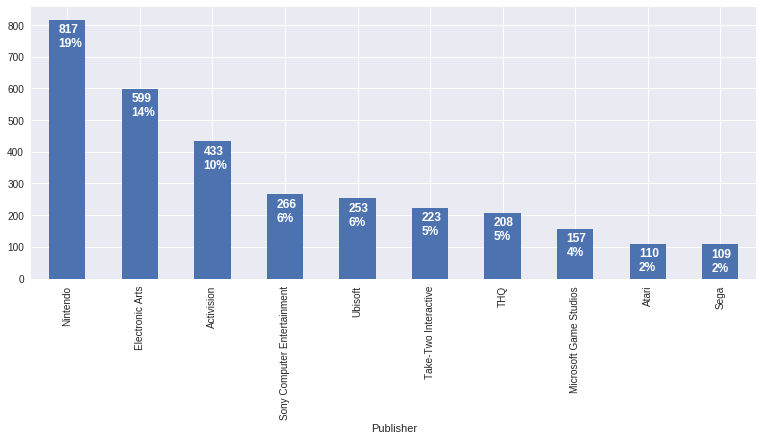

In [30]:
ax = vg_df.groupby('Publisher').sum().unstack().NA_Sales.sort_values(ascending=False).head(10).plot(kind='bar', figsize=(13, 5));

for p in ax.patches:
    ax.annotate(str( round( p.get_height() ) ) + "\n" + str(round( 100.0* p.get_height() /vg_df.NA_Sales.sum()) )+ "%", 
                (p.get_x() + 0.13, p.get_height()-85),
                color='white', fontsize=12, fontweight='bold')

#### European Union

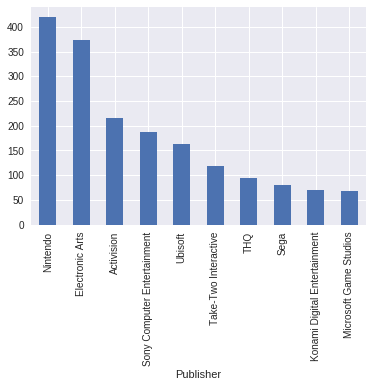

In [31]:
vg_df.groupby('Publisher').sum().unstack().EU_Sales.sort_values(ascending=False).head(10).plot(kind='bar');

#### Japan

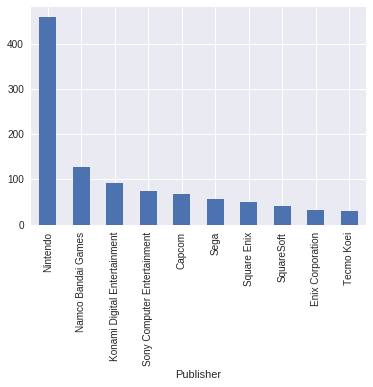

In [32]:
vg_df.groupby('Publisher').sum().unstack().JP_Sales.sort_values(ascending=False).head(10).plot(kind='bar');

#### Rest of the World

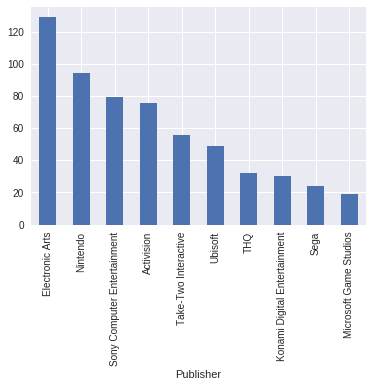

In [33]:
vg_df.groupby('Publisher').sum().unstack().Other_Sales.sort_values(ascending=False).head(10).plot(kind='bar');

The pattern is similar in North America, E.U. and rest of the world. Again, Japan stands out as a region with its own peculiarities. 

## Genre

#### North America

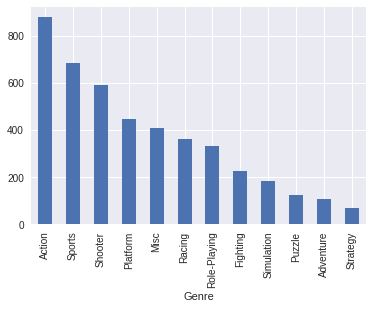

In [34]:
vg_df.groupby('Genre').sum().unstack().NA_Sales.sort_values(ascending=False).plot(kind='bar');

#### European Union

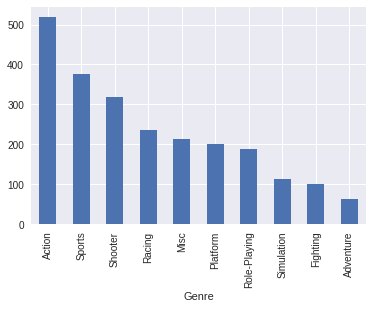

In [35]:
vg_df.groupby('Genre').sum().unstack().EU_Sales.sort_values(ascending=False).head(10).plot(kind='bar');

#### Japan

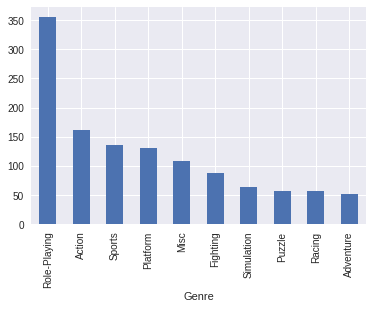

In [36]:
vg_df.groupby('Genre').sum().unstack().JP_Sales.sort_values(ascending=False).head(10).plot(kind='bar');

We knew already that the Japanese taste for games was already different, but when we quantified the sales it showed an even more interesting insight: their games are dominated by the role-playing genre!

#### Rest of the World

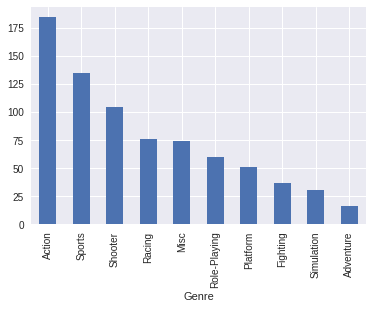

In [37]:
vg_df.groupby('Genre').sum().unstack().Other_Sales.sort_values(ascending=False).head(10).plot(kind='bar');

# Honourable Mentions

## Most Profitable Games of all Time

In [38]:
vg_df.sort_values('Global_Sales', ascending=False).head(10).Name

0                   Wii Sports
1            Super Mario Bros.
2               Mario Kart Wii
3            Wii Sports Resort
4     Pokemon Red/Pokemon Blue
5                       Tetris
6        New Super Mario Bros.
7                     Wii Play
8    New Super Mario Bros. Wii
9                    Duck Hunt
Name: Name, dtype: object

## Most Profitable Games in each Genre

In [39]:
#There are games with duplicate names (For each platform for example), so let's deal with this
x = vg_df.groupby(['Genre', 'Name']).sum().reset_index().groupby('Genre')

#A dataframe that will hold rankings, for nice display
best_selling_titles_by_genre_df = pd.DataFrame()

for name, group in x:
    temp_col = group.sort_values('Global_Sales', ascending=False).head(10).Name.reset_index(drop=True)
    best_selling_titles_by_genre_df[name] = temp_col

In [40]:
best_selling_titles_by_genre_df

,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
0,Grand Theft Auto V,Assassin's Creed,Super Smash Bros. Brawl,Wii Play,Super Mario Bros.,Tetris,Mario Kart Wii,Pokemon Red/Pokemon Blue,Call of Duty: Black Ops,Nintendogs,Wii Sports,Pokemon Stadium
1,Grand Theft Auto: San Andreas,Super Mario Land 2: 6 Golden Coins,Super Smash Bros. for Wii U and 3DS,Minecraft,New Super Mario Bros.,Brain Age 2: More Training in Minutes a Day,Mario Kart DS,Pokemon Gold/Pokemon Silver,Call of Duty: Modern Warfare 3,The Sims 3,Wii Sports Resort,Warzone 2100
2,Grand Theft Auto IV,L.A. Noire,Mortal Kombat,Kinect Adventures!,New Super Mario Bros. Wii,Dr. Mario,Gran Turismo 3: A-Spec,The Elder Scrolls V: Skyrim,Call of Duty: Black Ops II,Animal Crossing: Wild World,Wii Fit,StarCraft II: Wings of Liberty
3,Grand Theft Auto: Vice City,Zelda II: The Adventure of Link,WWE SmackDown vs Raw 2008,Brain Age: Train Your Brain in Minutes a Day,Super Mario World,Pac-Man,Need for Speed: Most Wanted,Pokemon Diamond/Pokemon Pearl,Duck Hunt,Animal Crossing: New Leaf,Wii Fit Plus,Warcraft II: Tides of Darkness
4,FIFA Soccer 13,Rugrats: Search For Reptar,Street Fighter IV,Guitar Hero III: Legends of Rock,Super Mario Bros. 3,Professor Layton and the Curious Village,Mario Kart 7,Pokemon Ruby/Pokemon Sapphire,Call of Duty: Ghosts,Cooking Mama,FIFA 15,Pokémon Trading Card Game
5,LEGO Star Wars: The Complete Saga,Club Penguin: Elite Penguin Force,Tekken 3,Just Dance 3,Super Mario 64,Tetris Worlds,Gran Turismo 4,Pokemon Black/Pokemon White,Call of Duty: Black Ops 3,MySims,FIFA 14,Command & Conquer: Red Alert
6,LEGO Batman: The Videogame,Myst,Super Smash Bros. Melee,Guitar Hero: World Tour,Super Mario Land,Professor Layton and the Diabolical Box,Need for Speed Underground 2,Pokémon Yellow: Special Pikachu Edition,Call of Duty: Modern Warfare 2,Tomodachi Life,FIFA 16,Pokémon Stadium 2
7,Grand Theft Auto III,Heavy Rain,Street Fighter II: The World Warrior,Just Dance 2,Donkey Kong Country,Professor Layton and the Unwound Future,Gran Turismo,Pokemon X/Pokemon Y,Call of Duty: Advanced Warfare,Microsoft Flight Simulator,Mario & Sonic at the Olympic Games,Sim Theme Park
8,Assassin's Creed III,Minecraft: Story Mode,Tekken 2,Mario Party DS,Super Mario Galaxy,Pac-Man Collection,Gran Turismo 5,Fallout 4,Call of Duty 4: Modern Warfare,The Sims: Bustin' Out,FIFA 12,Halo Wars
9,Assassin's Creed IV: Black Flag,Rise of the Tomb Raider,Fight Night Round 3,Just Dance 4,Super Mario 3D Land,WarioWare: Smooth Moves,Need for Speed Underground,Pokemon Omega Ruby/Pokemon Alpha Sapphire,Battlefield 3,Animal Crossing: City Folk,FIFA Soccer 11,Theme Hospital


My take over the best selling titles by genre:<br>
1- GTA dominates the action genre<br>
2- Wii sports stuff dominate the sports, followed by FIFAs<br>
3- Call of Duty dominates the shooting genre.<br>
4- The dataset need some cleaning, for example FIFA 2013 is listed as an action game while the rest of the FIFAs are listed as sports. Same for Assassin's Creed, some are listed as Action, others are adventure.<br>

# Conclusion

The sales and the number of releases go hand by hand, nothing special\suspicious.<br><br>

The "Action" genre seems to be the most resistant to sales decline.<br><br>

Genres seem to be reasonably persistent when we compare their number of releases and their revenues. However,  when we add to the picture the average revenue per game, the rankings change a lot:

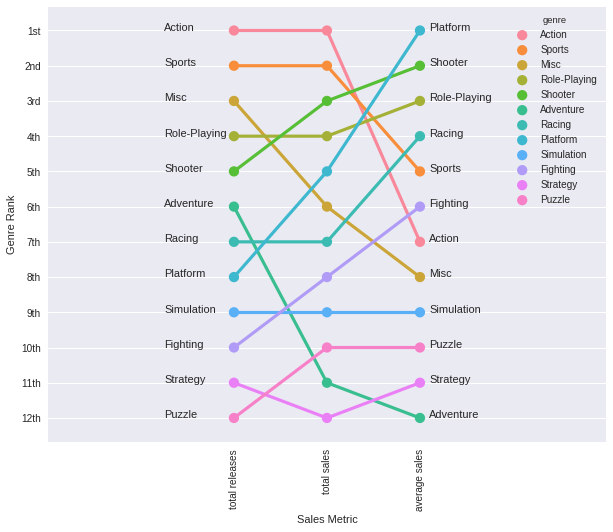

In [41]:
#First is the number of releases per genre, second is the sales per genre, third is the average sales per game per genre
genre_difference_metric = [vg_df.Genre.value_counts().index, vg_df.groupby(['Genre']).sum().Global_Sales.sort_values(ascending=False).index, vg_df.groupby(['Genre']).mean().Global_Sales.sort_values(ascending=False).index]

#Dataframe to be used for plotting.
genre_evolution_df = pd.DataFrame(columns=['genre', 'rank_type', 'rank'])

#Populate the dataframe
for metric in range(3):
    for genre in range(len(genre_difference_metric[metric])):
        genre_evolution_df = genre_evolution_df.append({'genre':genre_difference_metric[metric][genre], 'rank_type': metric, 'rank':genre},
                                   ignore_index=True)

        
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

sns.pointplot(x=genre_evolution_df.rank_type,
              y=12-genre_evolution_df['rank'], 
              hue=genre_evolution_df.genre)

for i in range(len(genre_difference_metric[0])):
    ax.text(-0.75, 12-i, genre_difference_metric[0][i], fontsize=11)
    ax.text(2.1, 12-i, genre_difference_metric[2][i], fontsize=11)
    
ax.set_xlim([-2,4])

xs = [0.0, 1.0, 2.0]
x_labels = ['total releases', 'total sales', 'average sales']
plt.xticks(xs, x_labels, rotation='vertical')

ax.set_xlabel('Sales Metric')

ys = range(1,13)
y_labels = ['12th', '11th', '10th', '9th', '8th', '7th', '6th', '5th', '4th', '3rd', '2nd', '1st']
plt.yticks(ys, y_labels)
ax.set_ylabel('Genre Rank')

plt.show();

<br><br><br>The critic score is more conservative than the user score, but it correlates much better with the sales. In fact, user score does not correlate at all (coefficient almost equal zero) with the games sales:<br>

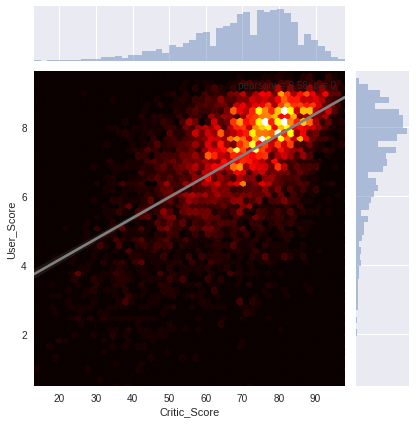

In [42]:
g = sns.jointplot(x = 'Critic_Score', 
              y = 'User_Score',
              data = vg_df, 
              kind = 'hex', 
              cmap= 'hot', 
              size=6)

#http://stackoverflow.com/questions/33288830/how-to-plot-regression-line-on-hexbins-with-seaborn
sns.regplot(vg_df.Critic_Score, vg_df.User_Score, ax=g.ax_joint, scatter=False, color='grey');

<br><br>Japan is a unique region when it comes to games. The rest of the world is more or less consistent, but Japan is different. For example, this is how the different genres sales ranked within each of the four regions:

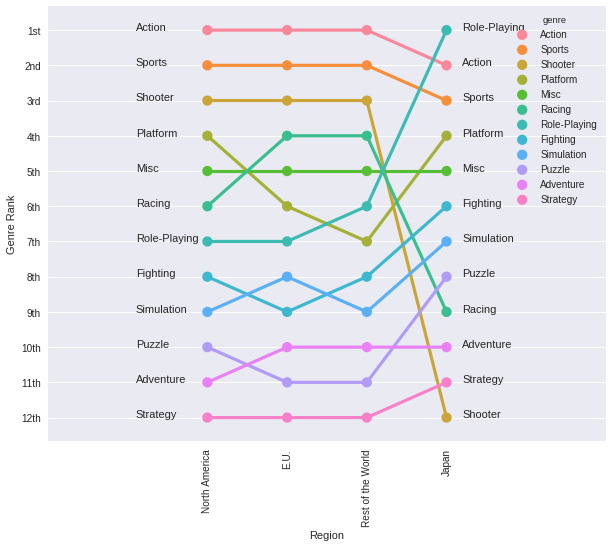

In [43]:
genre_geo_rankings = [vg_df.groupby('Genre').sum().unstack().NA_Sales.sort_values(ascending=False).index, 
                      vg_df.groupby('Genre').sum().unstack().EU_Sales.sort_values(ascending=False).index,
                      vg_df.groupby('Genre').sum().unstack().Other_Sales.sort_values(ascending=False).index,
                      vg_df.groupby('Genre').sum().unstack().JP_Sales.sort_values(ascending=False).index
                      ]

#First is the number of releases per genre, second is the sales per genre, third is the average sales per game per genre
genre_geo_rank_df = pd.DataFrame(columns=['genre', 'rank_type', 'rank'])

#for metric in genre_difference_metric:
for region in range(4):
    for genre in range(len(genre_geo_rankings[region])):
        genre_geo_rank_df = genre_geo_rank_df.append({'genre':genre_geo_rankings[region][genre], 'rank_type': region, 'rank':genre},
                                   ignore_index=True)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

sns.pointplot(x=genre_geo_rank_df.rank_type,
              y=12-genre_geo_rank_df['rank'], 
              hue=genre_geo_rank_df.genre)

for i in range(len(genre_geo_rankings[0])):
    ax.text(-0.9, 12-i, genre_geo_rankings[0][i], fontsize=11)
    ax.text(3.2, 12-i, genre_geo_rankings[3][i], fontsize=11)
    
ax.set_xlim([-2,5])

xs = [0.0, 1.0, 2.0, 3.0]
x_labels = ['North America', 'E.U.', 'Rest of the World', 'Japan']
plt.xticks(xs, x_labels, rotation='vertical')
ax.set_xlabel('Region')

ys = range(1,13)
y_labels = ['12th', '11th', '10th', '9th', '8th', '7th', '6th', '5th', '4th', '3rd', '2nd', '1st']
plt.yticks(ys, y_labels)
ax.set_ylabel('Genre Rank')

plt.show();

The Japanese also showed a strong inclination to Nintendo as a publisher, and for the "Role Playing" genre.

The top publishers list is a list made of the top 20 publishers that consistently made it to the top 10 lists of different metrics (e.g. top selling games, top total sales..etc)

<br>The top publishers are:<br>
Electronic Arts<br>
Activision<br>
Namco Bandai Games<br>
Ubisoft<br>
Konami Digital Entertainment<br>
THQ<br>
Nintendo<br>
Sony Computer Entertainment<br>
Sega<br>
Take-Two Interactive<br>
Sony Computer Entertainment Europe<br>
Microsoft Game Studios<br>
Enix Corporation<br>
Bethesda Softworks<br>
SquareSoft<br>
Take-Two Interactive<br>
LucasArts<br>
989 Studios<br>
Hasbro Interactive<br>
Universal Interactive<br>

These 20 companies make up a little over half (51.85%) of all the games produced, and a little over three quarters (76%) of all the global sales. This follows the general pattern found everywhere in this dataset: the exponential decay.